# <center><font color='MediumSeaGreen'> _Módulo Machine Learning G45_</font>
# <center><font color='MediumSeaGreen'> Desafío evaluado - Inferencia de tópicos con EM</font>
## <center> _Algoritmos de clasificación (Parte II)_ 
    
### <center><b> Bárbara Pérez </b><center>

____________

## <font color='MediumSeaGreen'>Requerimientos</font>

- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los <span style='background:gainsboro'><font color='dimgray'>plt.Rcparams</font></span>csv se encuentra en la carpeta <span style='background:gainsboro'><font color='dimgray'>plt.Rcparams</font></span>dump.


- Cada <span style='background:gainsboro'><font color='dimgray'>plt.Rcparams</font></span>csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.


- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.


- Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

_____________

## <font color='MediumSeaGreen'>Ejercicio 1: Preparar el ambiente de trabajo</font>

- Importe los módulos <span style='background:gainsboro'><font color='dimgray'>numpy</font></span>, <span style='background:gainsboro'><font color='dimgray'>pandas</font></span>, <span style='background:gainsboro'><font color='dimgray'>matplotlib</font></span>, <span style='background:gainsboro'><font color='dimgray'>seaborn</font></span>, <span style='background:gainsboro'><font color='dimgray'>glob</font></span> y <span style='background:gainsboro'><font color='dimgray'>os</font></span> siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta <span style='background:gainsboro'><font color='dimgray'>dump</font></span>.


- Para ello genere un objeto que guarde en una lista todos los archivos alojados en <span style='background:gainsboro'><font color='dimgray'>dump</font></span> utilizando <span style='background:gainsboro'><font color='dimgray'>glob.glob</font></span> y <span style='background:gainsboro'><font color='dimgray'>os.getcwd()</font></span> para extraer las rutas absolutas. Posteriormente genere un objeto <span style='background:gainsboro'><font color='dimgray'>pd.DataFrame</font></span> que contenga todos los <span style='background:gainsboro'><font color='dimgray'>csv</font></span>.


- Asegúrese de eliminar la columna <span style='background:gainsboro'><font color='dimgray'>Unnamed: <font color='Maroon'>0</font></span> que se genera por defecto.

In [1]:
#librerías clásicas
import matplotlib.pyplot as plt #version 3.5.2
import pandas as pd  #version 1.4.3
import seaborn as sns  #version 0.11.2
import numpy as np  #version 1.23.0

#librería para análisis exploratorio
import pandas_profiling #version 3.2.0

#Libreria para manejo de archivos a nuvel de sistema operativo
import os
import glob

#Libreria para preprocesamiento
from sklearn.preprocessing import LabelEncoder

#Libreria para modelamiento
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

#Libreria para las métricas
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

#Eliminar los mensajes de advertencia
import warnings
warnings.filterwarnings ('ignore')

In [2]:
#Importamos las funciones entregadas por academia
import lec6_graphs as gfs

In [3]:
#importamos librerias para cambiar los tamaños de visualización del Jupyter
from IPython.display import display, HTML
#mejoramos la visualización
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
#agregamos javascript y link para mostrar/ocultar el código
HTML(
    '''
    <script>
    code_show=false; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <h4>
    Para ocultar/visualizar el código, presionar <a href="javascript:code_toggle()">AQUI</a>.</h4>
    '''
)

In [4]:
#importamos nuestras funciones entregadas por el profesor
import funciones_auxiliares as fas

In [5]:
#utilizamos la función del profesor para importar la data
def load_data(path):
   '''
   carga el dataset
   '''
   # Definiendo la carga de todos los datos
   all_files = glob.glob(path + "/*.csv")
   li = []
   for filename in all_files:
       file = pd.read_csv(filename, index_col=None, header=0)
       li.append(file)
   data = pd.concat(li, axis=0, ignore_index=True)
   return data

In [6]:
#importamos la data
path = os.getcwd()+'/dump'
df=load_data(path)

In [7]:
#inspeccionamos el df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9489 entries, 0 to 9488
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9489 non-null   object
 1   0           9489 non-null   object
 2   1           9489 non-null   object
 3   2           9489 non-null   object
 4   3           9489 non-null   object
dtypes: object(5)
memory usage: 370.8+ KB


Observamos que no hay datos perdidos en nuestro Data Frame

In [8]:
#verificamos las columnas
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3'], dtype='object')

In [9]:
#revisamos la data
df.sample(10)

,Unnamed: 0,0,1,2,3
7454,163,Red Hot Chili Peppers,rock,Storm In A Teacup,"""Oh good god in heaven almighty, heavens to Mu..."
6090,245,Nicki Minaj,pop,Set It Off,"(Talking: Nicki Minaj) \n Chea, Nicki Minaj, D..."
4460,138,Megadeth,metal,Bodies,"This thing called ""life"" goes by so quickly \n..."
4200,83,Led Zeppelin,rock,The Girl I Love She Got Long Black Wavy Hair,"Whoa, the girl I love, she got long black wavy..."
5056,142,Michael Jackson,pop,You Can't Win,"You can't win, you can't break even \n And you..."
3690,254,Kanye West,hiphop,Wack Niggaz,"(Feat. Talib Kweli, Common, Consequence) \n (S..."
5113,199,Michael Jackson,pop,What More Can I Give,"(Michael Jackson) \n Ho... hey, hey \n No, no,..."
1110,33,Bruce Springsteen,rock,Darkness On The Edge Of Town,They're still racing out at the Trestles \n Bu...
1722,7,Carly Rae Jepsen,pop,Sweet Talker,(I can see) \n Sweet talker \n I'm not gonna s...
4931,17,Michael Jackson,pop,Shoo-Be-Doo-Be-Doo-Da-Day,"Your precious sweetheart, she's so faithful \n..."


In [10]:
df.shape

(9489, 5)

In [11]:
#eliminamos la columna unnamed
df = df.drop(columns='Unnamed: 0')

In [12]:
#le asignamos nombres a las columnas
df.columns = ['artista','genero','cancion','letra']

In [13]:
#Se muestran los cambios realizados
df.sample()

,artista,genero,cancion,letra
8036,Spice Girls,pop,We're Gonna Make It Happen,"Time is now, we want release \n Break on throu..."


___________

## <font color='MediumSeaGreen'>Ejercicio 2: Matriz de ocurrencias</font>

- Importe la clase <span style='background:gainsboro'><font color='dimgray'>CountVectorizer</font></span> dentro de los módulos <span style='background:gainsboro'><font color='dimgray'>feature_extraction.text</font></span> de la librería <span style='background:gainsboro'><font color='dimgray'>sklearn</font></span>.


- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.


- Con la clase inicializada, incorpore las letras con el método <span style='background:gainsboro'><font color='dimgray'>fit_transform</font></span> y guarde los resultados en un nuevo objeto.

In [14]:
#importamos la libreria solicitada
from sklearn.feature_extraction.text import CountVectorizer

#utilizamos y modificamos el ejemplo del desafío

# instanciamos un objeto con las 5000 palabras mas repetidas
count_vectorizer=CountVectorizer(stop_words='english', max_features=5000)

# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df['letra'])

# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()

# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [15]:
#verificamos que la cantidad de palabras obtenidas sea igual a la cantidad de frecuencias
print(f"Cantidad de palabras    => {len(words)}")
print(f"Cantidad de frecuencias => {len(words_freq)}")

Cantidad de palabras    => 5000
Cantidad de frecuencias => 5000


In [16]:
#creamos un df para las palabras y sus frecuencias
df_palabras = pd.DataFrame({'words': words,'words_freq': words_freq })

In [17]:
#revisamos el df
df_palabras.sample(5)

,words,words_freq
39,ac,40
4885,wishes,42
4807,weeds,39
4894,woah,149
2562,louder,104


In [18]:
#obtenemos las palabras mas frecuentes y las ordenamos
df_palabras_mas_frecuentes = df_palabras.sort_values(by=['words_freq'], ascending=False)

____________________

## <font color='MediumSeaGreen'>Ejercicio 3: Entrenamiento del Modelo
</font>

- Importe <span style='background:gainsboro'><font color='dimgray'>sklearn.decomposition.LatentDirichletAllocation</font></span> y <span style='background:gainsboro'><font color='dimgray'>sklearn.model_selection.GridSearchCV</font></span>.


- Genere una búsqueda de grilla con los siguientes hiper parámetros:
    - <span style='background:gainsboro'><font color='dimgray'>n_components: <font color='Maroon'>[5, 10, 15]</font></span>.
    - <span style='background:gainsboro'><font color='dimgray'>learning_decay: <font color='Maroon'>[0.7, 0.5]</font></span>.


- Entrene la búsqueda de grilla con las letras en un formato vectorizado con <span style='background:gainsboro'><font color='dimgray'>CountVectorizer</font></span>.


- Reporte brevemente cuál es la mejor combinación de hiper parámetros

### <font color='Gray'> Digresión: Latent Dirichlet Allocation </font></span>

Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de texto. El proceso de inferencia se puede resumir en los siguientes pasos:

- Cada documento dentro del corpus se puede entender como una mezcla de tópicos **comunes a nivel de corpus**.

- Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y sus palabras.

La API de <span style='background:gainsboro'><font color='dimgray'>sklearn.decomposition.LatentDirichletAllocation</font></span> presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:

   
- <span style='background:gainsboro'><font color='dimgray'>n_components</font></span>: Cantidad de tópicos a inferir en un corpus.


- <span style='background:gainsboro'><font color='dimgray'>learning_method</font></span>: Forma en la que entran los datos en entrenamiento. Cuando es 'batch', se ingresa la matriz de entrenamiento completa. Cuando es 'online', la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.


- <span style='background:gainsboro'><font color='dimgray'>learning_decay</font></span>: Tasa de aprendizaje en la función de pérdida. Cuando se implementa con <span style='background:gainsboro'><font color='dimgray'>learning_method=<font color='Maroon'>'online'</font></span>, el modelo se entrena con Gradiente Estocástico Descendente.
    
    
- <span style='background:gainsboro'><font color='dimgray'>Perplejidad</font></span>: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En función a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.

In [19]:
#importamos las librerías solicitadas
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [20]:
#creamos un diccionario con los hiperparámetros del desafío
params = {'n_components': [5,10,15],
          'learning_decay': [0.7,0.5]
         }

In [21]:
#instanciamos un objeto de la grilla
grilla = GridSearchCV(LatentDirichletAllocation(learning_method='online')
                      , param_grid=params
                      , n_jobs=-1
                      , verbose=1)

In [22]:
#entrenamos la grilla en el formato vectorizado
grilla.fit(count_vectorizer_fit)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online'),
             n_jobs=-1,
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]},
             verbose=1)

In [23]:
#reportamos la mejor combinación de hiperparámetros
grilla.best_estimator_

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          n_components=5)

In [24]:
grilla.best_params_

{'learning_decay': 0.5, 'n_components': 5}

__________

## <font color='MediumSeaGreen'>Ejercicio 4 : Inferencia e Identificación de Tópicos </font>

- En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz de atributos de las letras.


- Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

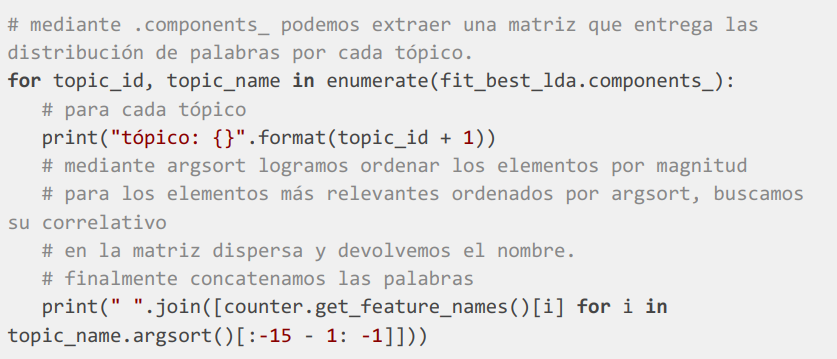

- Comente a qué tópicos está asociada cada clase inferida

In [25]:
#creamos el modelo con la matriz de atributos de las letra
#en base a la mejor combinación de hiperparámetros
best_lda = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=12345,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [26]:
#entrenamos el modelo
best_lda.fit(count_vectorizer_fit)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=12345, verbose=1)

In [27]:
#mostramos la matriz de componentes
best_lda.components_

array([[ 0.20342074,  0.20363263,  0.20676044, ...,  0.20323713,
         0.20175039,  0.20144964],
       [ 0.88790915, 99.98525144, 16.95474198, ..., 31.64287003,
        34.25296812, 32.7292738 ],
       [ 0.20566563, 27.71521702, 54.61815399, ...,  7.11217541,
         0.20526429,  0.20952407],
       [35.67664822, 13.4275947 ,  0.20883722, ...,  9.24167607,
         0.20444577,  0.20219736],
       [ 2.31106657,  0.20176015,  8.04349997, ...,  0.20995525,
         0.20154045,  0.20182214]])

In [28]:
#mostramos la cantidad de componentes
best_lda.n_components

5

In [29]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
life god die death world blood eyes soul time dead light pain hell away end
tópico: 2
like got yo ain don man cause know rock shit yeah just ya niggaz time
tópico: 3
like fuck shit nigga don know niggas bitch yeah ain just la cause ya got
tópico: 4
man like em black just got old money new said big white did right left
tópico: 5
love don know oh just yeah ll baby ve got let want like time come


Listamos los obtenidos en el chunk anterior cuando ejecutamos el kernel:

**tópico 1:**: *'life god die death world blood eyes soul time dead light pain hell away end.'*

**tópico 2:** *'like got yo ain don man cause know rock shit yeah just ya niggaz time.'*

**tópico 3:** *'like fuck shit nigga don know niggas bitch yeah ain just la cause ya got.'*

**tópico 4:** *'man like em black just got old money new said big white did right left.'*

**tópico 5:** *'love don know oh just yeah ll baby ve got let want like time come'*

### Los géneros aparentes por tópico son:
* **tópico 1** => *metal*
* **tópico 2** => *rock*
* **tópico 3** => *rap/hip hop*
* **tópico 4** => *rap/hip hop*
* **tópico 5** => *pop*

__________

## <font color='MediumSeaGreen'>Ejercicio 5: Identificación de probabilidades </font>

- En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.

- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:

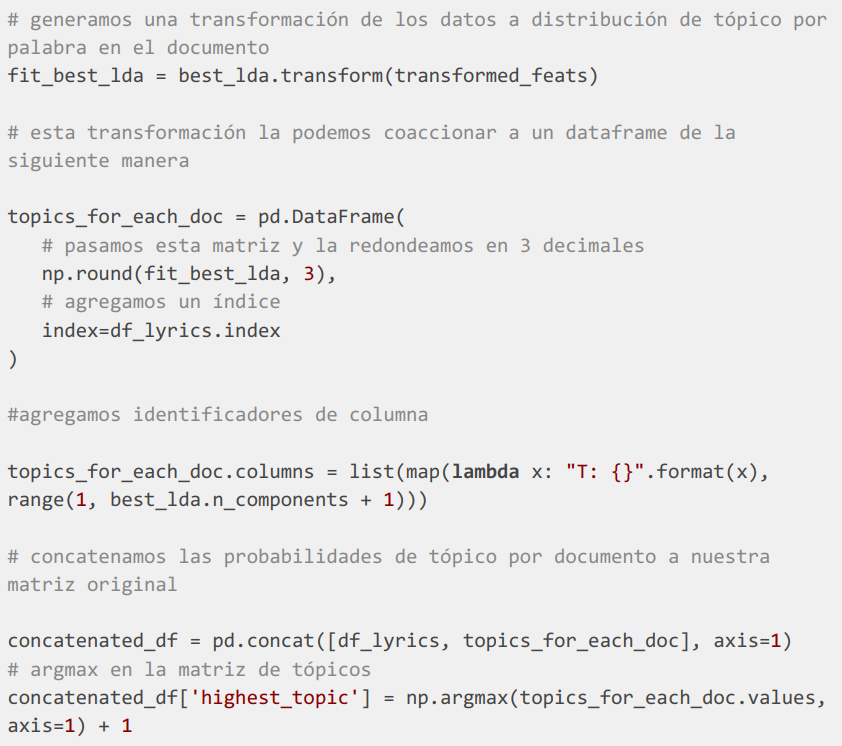

- Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.


- Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.


- Grafique la distribución de las probabilidades para algún artista en específico

In [30]:
#implementamos el código del desafío
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(count_vectorizer_fit)

In [31]:
# esta transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
    # pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda, 3),
    # agregamos un índice
    index=df.index
)

In [32]:
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))

In [33]:
#mostramos el df
topics_for_each_doc

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.603,0.006,0.006,0.251,0.134
1,0.563,0.313,0.005,0.113,0.005
2,0.002,0.002,0.002,0.587,0.408
3,0.410,0.226,0.003,0.003,0.358
4,0.644,0.003,0.003,0.258,0.092
...,...,...,...,...,...
9484,0.865,0.003,0.003,0.003,0.127
9485,0.003,0.035,0.119,0.003,0.840
9486,0.219,0.005,0.005,0.005,0.766
9487,0.010,0.181,0.081,0.010,0.718


In [34]:
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)

In [35]:
#mostramos el nuevo df
concatenated_df

,artista,genero,cancion,letra,T: 1,T: 2,T: 3,T: 4,T: 5
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.603,0.006,0.006,0.251,0.134
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.563,0.313,0.005,0.113,0.005
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.002,0.002,0.002,0.587,0.408
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.410,0.226,0.003,0.003,0.358
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.644,0.003,0.003,0.258,0.092
...,...,...,...,...,...,...,...,...,...
9484,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n...",0.865,0.003,0.003,0.003,0.127
9485,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...,0.003,0.035,0.119,0.003,0.840
9486,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...,0.219,0.005,0.005,0.005,0.766
9487,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...,0.010,0.181,0.081,0.010,0.718


In [36]:
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [37]:
#volvemos a mostrar el df resultante
concatenated_df

,artista,genero,cancion,letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.603,0.006,0.006,0.251,0.134,1
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.563,0.313,0.005,0.113,0.005,1
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.002,0.002,0.002,0.587,0.408,4
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.410,0.226,0.003,0.003,0.358,1
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.644,0.003,0.003,0.258,0.092,1
...,...,...,...,...,...,...,...,...,...,...
9484,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n...",0.865,0.003,0.003,0.003,0.127,1
9485,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...,0.003,0.035,0.119,0.003,0.840,5
9486,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...,0.219,0.005,0.005,0.005,0.766,5
9487,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...,0.010,0.181,0.081,0.010,0.718,5


In [38]:
#generamos la matriz de correlaciones
corr=topics_for_each_doc.corr()

<AxesSubplot:>

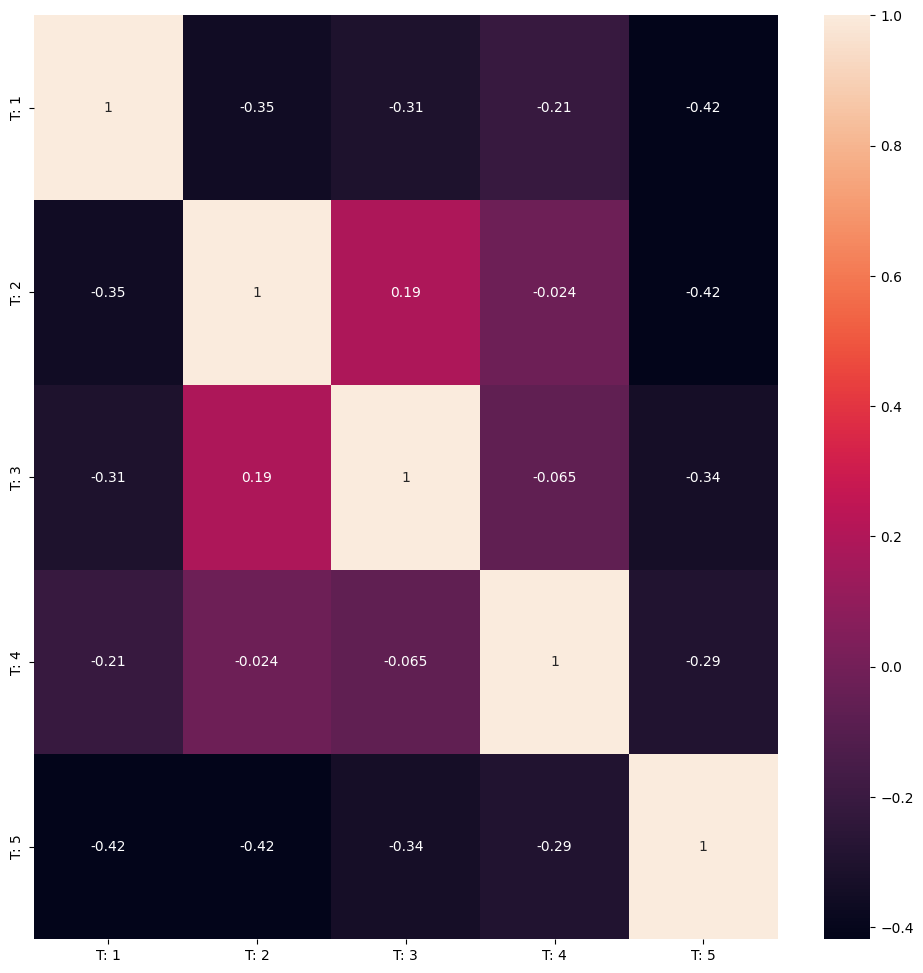

In [39]:
#creamos un heatmap para visualizar las correlaciones
plt.rcParams['figure.figsize'] = (12, 12)
sns.heatmap(corr, annot=True)

###  Las principales asociaciones existentes son:
* Tópico 2 - Tópico 3

### Identificaremos las probabilidades de pertenencia a cada tópico, por artista

In [40]:
#obtenemos los artistas y los ordenamos alfabéticamente en forma descendente
artistas = concatenated_df['artista'].unique()
artista = artistas.sort()

In [41]:
#los listamos
artistas

array(['A Tribe Called Quest', 'Anthrax', 'Black Star', 'Bob Dylan',
       'Britney Spears', 'Bruce Springsteen', 'Cannibal Corpse',
       'Carly Rae Jepsen', 'De La Soul', 'Deicide', 'Dr. Dre', 'Dua Lipa',
       'Eminem', 'Faith No More', 'Ghostface Killah', 'Gorgoroth',
       'Immortal', 'Incubus', 'Iron Maiden', 'Kanye West',
       'Kendrick Lamar', 'Killer Mike', 'Kiss', 'Led Zeppelin', 'Lorde',
       'MF Doom', 'Mayhem', 'Megadeth', 'Meshuggah', 'Metallica',
       'Method Man', 'Michael Jackson', 'Mobb Deep', 'Modest Mouse',
       'Mos Def', 'Necrophagist', 'Nickelback', 'Nicki Minaj', 'Oasis',
       'Opeth', 'Pink Floyd', 'Public Enemy', 'Queen', 'Radiohead',
       'Raekwon', 'Rage Against The Machine', 'Red Hot Chili Peppers',
       'Rush', 'SIA', 'Sam Smith', 'Slayer', 'Spice Girls',
       'System of a Down', 'The Beatles', 'The Clash', 'The Doors',
       'The Smashing Pumpkins', 'The Smiths', 'Tool', 'Vital Remains',
       'Weezer'], dtype=object)

In [42]:
#creamos un diccionario para almacenar los promedios como listas
#y asi poder crear el dataframe
promedios = {}
#iteramos sobre los promedios
for p in range(1, 6):
    #creamos una lista vacía para cada tópico
    promedios['T: '+str(p)] = []
    #iteramos sobre los artistas    
    for a in artistas:
        #agregamos el promedio del tópico a la lista
        promedios['T: '+str(p)].append(concatenated_df[concatenated_df['artista'] == a]['T: '+str(p)].mean())

In [43]:
#creamos el df
df_promedios_por_artista = pd.DataFrame({'artista': artistas
                                         , 'T: 1': promedios['T: 1']
                                         , 'T: 2': promedios['T: 2']
                                         , 'T: 3': promedios['T: 3']
                                         , 'T: 4': promedios['T: 4']
                                         , 'T: 5': promedios['T: 5']
                                        })

In [44]:
#lo visualizamos
df_promedios_por_artista

,artista,T: 1,T: 2,T: 3,T: 4,T: 5
0,A Tribe Called Quest,0.054711,0.563079,0.110175,0.113991,0.157982
1,Anthrax,0.353465,0.063976,0.046582,0.201818,0.334159
2,Black Star,0.141217,0.625261,0.046739,0.116348,0.070565
3,Bob Dylan,0.166740,0.052568,0.019394,0.249119,0.512110
4,Britney Spears,0.054985,0.109622,0.102560,0.051969,0.680988
...,...,...,...,...,...,...
56,The Smashing Pumpkins,0.262500,0.024051,0.020331,0.093453,0.599575
57,The Smiths,0.156403,0.041571,0.041948,0.189052,0.571052
58,Tool,0.375677,0.052097,0.098823,0.124903,0.348548
59,Vital Remains,0.902800,0.020333,0.005867,0.043333,0.027578


In [45]:
#creamos una función para graficar el histograma de las probabilidades
#de cualquier artista
def histograma_prob_artista(df, artista):
    data = df[df['artista']==artista].loc[:,'T: 1':'T: 5']
    sns.distplot(data
            , kde = False
            , bins = 10
            )
    plt.title('Histograma de probabilidades de '+artista, weight='bold') 

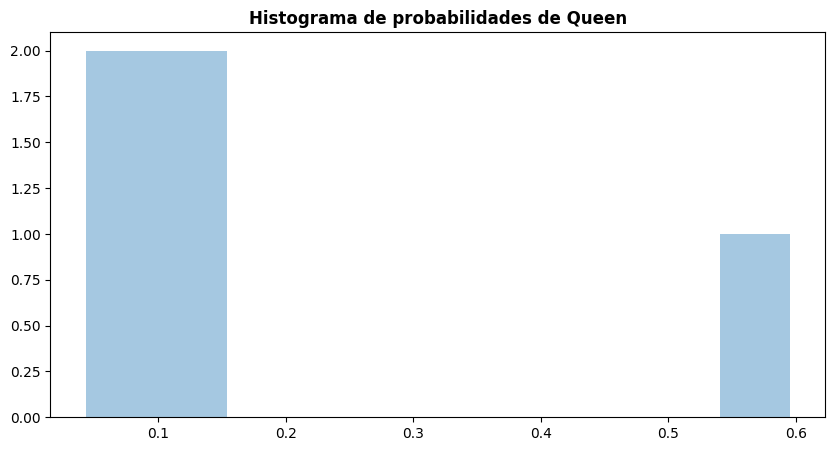

In [46]:
#graficaremos un histograma sobre las probabilidades de un artista
plt.rcParams['figure.figsize'] = (10, 5)
histograma_prob_artista(df_promedios_por_artista, 'Queen')


______________________________________________________________